In [1]:
import kagglehub
yaseenah_ham1000_segmentation_and_classification_path = kagglehub.dataset_download('surajghuwalewala/ham1000-segmentation-and-classification')
yaseenah_sdp_model_2_pytorch_default_1_path = kagglehub.model_download('sailakshman11/sdp_model_2/PyTorch/default/1')

print('Data source import complete.')


  0%|          | 0.00/89.2M [00:00<?, ?B/s]
  1%|          | 1.00M/89.2M [00:00<00:52, 1.75MB/s]
  2%|▏         | 2.00M/89.2M [00:00<00:26, 3.39MB/s]
  4%|▍         | 4.00M/89.2M [00:00<00:12, 7.12MB/s]
  9%|▉         | 8.00M/89.2M [00:00<00:05, 15.1MB/s]
 13%|█▎        | 12.0M/89.2M [00:01<00:03, 21.2MB/s]
 18%|█▊        | 16.0M/89.2M [00:01<00:02, 25.9MB/s]
 22%|██▏       | 20.0M/89.2M [00:01<00:02, 29.5MB/s]
 27%|██▋       | 24.0M/89.2M [00:01<00:02, 32.1MB/s]
 31%|███▏      | 28.0M/89.2M [00:01<00:01, 34.2MB/s]
 36%|███▌      | 32.0M/89.2M [00:01<00:01, 36.1MB/s]
 40%|████      | 36.0M/89.2M [00:01<00:01, 37.2MB/s]
 45%|████▍     | 40.0M/89.2M [00:01<00:01, 37.8MB/s]
 49%|████▉     | 44.0M/89.2M [00:01<00:01, 38.3MB/s]
 54%|█████▍    | 48.0M/89.2M [00:01<00:01, 37.6MB/s]
 58%|█████▊    | 52.0M/89.2M [00:02<00:01, 38.0MB/s]
 63%|██████▎   | 56.0M/89.2M [00:02<00:00, 38.2MB/s]
 67%|██████▋   | 60.0M/89.2M [00:02<00:00, 39.1MB/s]
 72%|███████▏  | 64.0M/89.2M [00:02<00:00, 39.1MB/s]
 

Data source import complete.


In [2]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
image_folder = "/kaggle/input/ham1000-segmentation-and-classification/images"  # Your unified image folder
csv_path = "/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv"      # Your CSV file

# Load CSV
df = pd.read_csv(csv_path)

# Ensure the image path column is full path
df['filename'] = df['image'].apply(lambda x: os.path.join(image_folder, f"{x}.jpg"))

# Derive class label: Get the index of the column with value 1 for each row
class_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
df['label'] = df[class_columns].idxmax(axis=1)  # Converts to string label like "class_3"

# Define ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training generator
train_generator = datagen.flow_from_dataframe(
    df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # For multiclass classification
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = datagen.flow_from_dataframe(
    df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

print("TensorFlow dataset ready for training!")

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
TensorFlow dataset ready for training!


In [3]:
import pandas as pd
import os

# Load CSV
csv_path = "/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv"
df1 = pd.read_csv(csv_path)

# Count images per class (assuming each image belongs to only one class)
class_counts = df1[class_columns].sum().astype(int)

# Print class-wise count
for class_name, count in class_counts.items():
    print(f"Number of images in {class_name}: {count}")

# Total number of images
print(f"Total number of images in dataset: {len(df1)}")

Number of images in MEL: 1113
Number of images in NV: 6705
Number of images in BCC: 514
Number of images in AKIEC: 327
Number of images in BKL: 1099
Number of images in DF: 115
Number of images in VASC: 142
Total number of images in dataset: 10015


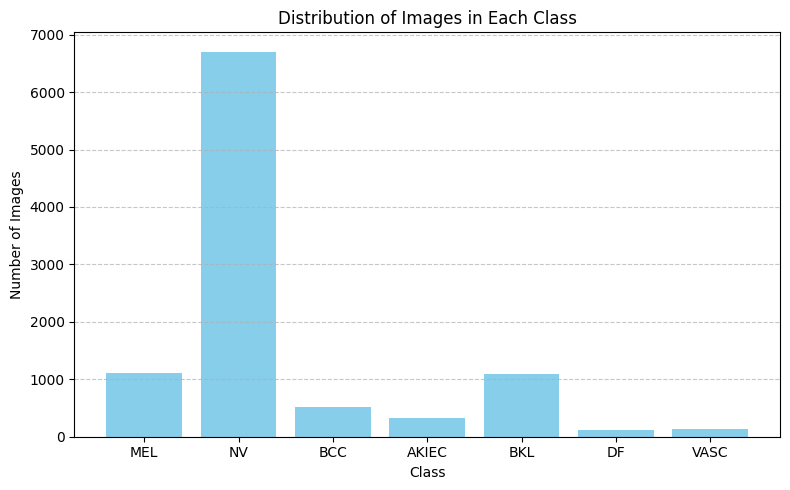

In [4]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [5]:
import os
import cv2
import numpy as np
import pandas as pd

def remove_hair(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    b_hat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, k)
    _, thresh = cv2.threshold(b_hat, 10, 255, cv2.THRESH_BINARY)
    return cv2.inpaint(image, thresh, 1, cv2.INPAINT_TELEA)

def process_images_from_dataframe(df, image_folder, output_folder, extension=".jpg"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for idx, row in df.iterrows():
        image_filename = row['image'] + extension
        image_path = os.path.join(image_folder, image_filename)

        if not os.path.exists(image_path):
            print(f"Missing: {image_path}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load: {image_path}")
            continue

        cleaned = remove_hair(image)
        output_path = os.path.join(output_folder, image_filename)
        cv2.imwrite(output_path, cleaned)

    print(f"All images processed and saved to: {output_folder}")

# === Configurations ===
csv_path = "/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv"
image_folder = "/kaggle/input/ham1000-segmentation-and-classification/images"
output_folder = "/kaggle/working/cleaned_images/"

# Load CSV
df = pd.read_csv(csv_path)

# Process images
process_images_from_dataframe(df, image_folder, output_folder, extension=".jpg")

All images processed and saved to: /kaggle/working/cleaned_images/


In [7]:
cleaned_count = len(os.listdir(output_folder)) if os.path.exists(output_folder) else 0

print("Total Number of cleaned images: ", cleaned_count)

Total Number of cleaned images:  10015


In [8]:
import os
import random

# Folder path
folder_path = "/kaggle/working/cleaned_images"

# List all files
all_images = os.listdir(folder_path)

# Pick 5 random image names (or fewer if not enough images)
random_images = random.sample(all_images, min(5, len(all_images)))

# Print them
print("Random sample of image files:")
for img in random_images:
    print(img)

Random sample of image files:
ISIC_0032533.jpg
ISIC_0030222.jpg
ISIC_0026247.jpg
ISIC_0028254.jpg
ISIC_0024999.jpg


In [9]:
import shutil

# Folder you want to zip
folder_to_zip = "/kaggle/working/cleaned_images"

# Output zip file path (without .zip extension)
output_zip = "/kaggle/working/cleaned_images_zip"

# Create the zip file
shutil.make_archive(output_zip, 'zip', folder_to_zip)

print(f"Folder zipped at: {output_zip}.zip")

Folder zipped at: /kaggle/working/cleaned_images_zip.zip


In [10]:
from google.colab import files
uploaded = files.upload()


Saving final_unet_skin_lesion.h5 to final_unet_skin_lesion.h5


In [11]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import tensorflow.keras.backend as K

# Custom Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss
def dice_loss(y_true, y_pred):
    return 1. - dice_coefficient(y_true, y_pred)

# IOU (Intersection over Union)
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Load model without compilation
model_path = '/content/final_unet_skin_lesion.h5'
model = tf.keras.models.load_model(model_path, compile=False)  # Force compile=False

# Get expected input size (e.g., 128x128)
input_shape = model.input_shape[1:3]  # (128, 128)
print(f"Expected model input shape: {input_shape}")

# Recompile the model with correct loss & metrics
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient, iou_metric])
model.summary()

Expected model input shape: (128, 128)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 128, 128,  │          0 │ conv2d_19[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ leaky_re_lu_18[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ leaky_re_lu_19[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ dropout_9[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_20      │ (None, 64, 64,    │          0 │ conv2d_21[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ leaky_re_lu_20[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_21      │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ leaky_re_lu_21[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ dropout_10[0][0]

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [12]:
from tensorflow.keras.utils import plot_model

# Assuming your model is named 'model'
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

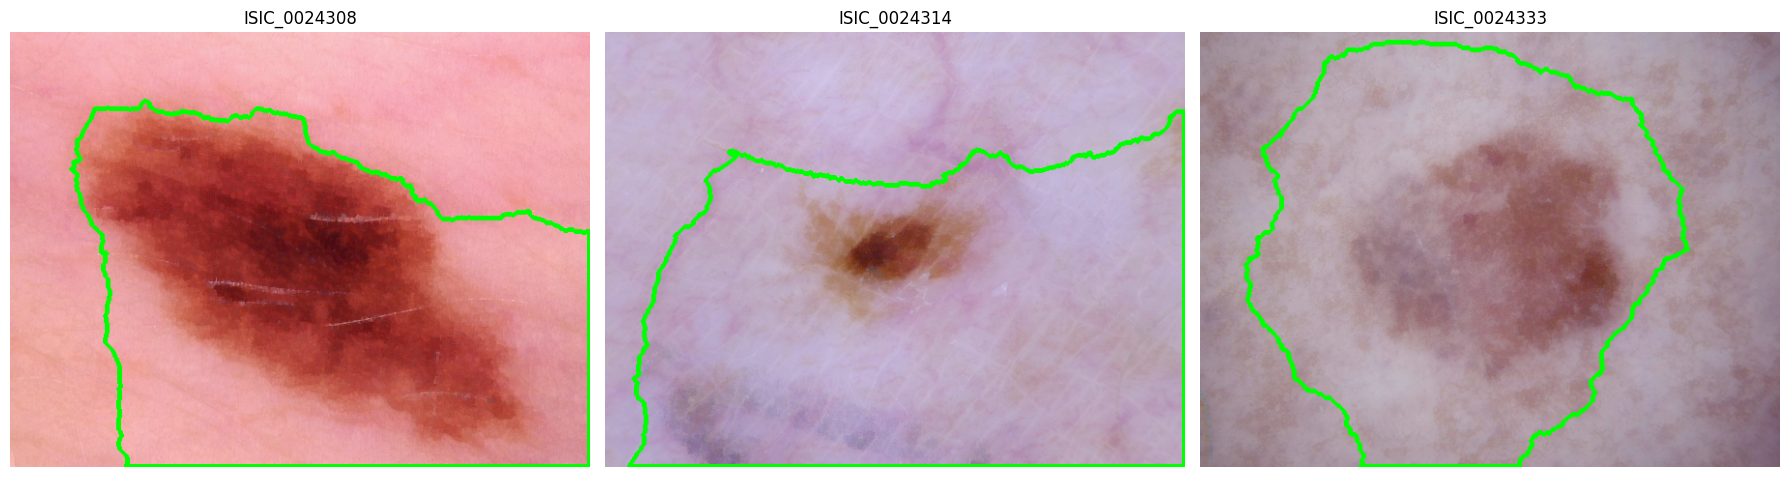

In [14]:
def create_mask(image_path, output_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read: {image_path}")
        return None

    mask = np.zeros(image.shape[:2], np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)
    rect = (10, 10, image.shape[1] - 10, image.shape[0] - 10)

    cv2.grabCut(image, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)

    # Create binary mask: 0 for background, 255 for foreground
    binary_mask = np.where((mask == 2) | (mask == 0), 0, 255).astype('uint8')

    # Save the mask
    cv2.imwrite(output_path, binary_mask)
    return binary_mask

# Function to draw contours on the original image using the mask
def draw_contours(original_image, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour_image = original_image.copy()
    if contours:
        cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 3)

    return contour_image

def process_image(image_path, output_mask_path):
    binary_mask = create_mask(image_path, output_mask_path)
    if binary_mask is None:
        return None

    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    return draw_contours(original_image, binary_mask)

image_paths = [
    '/kaggle/working/cleaned_images/ISIC_0024308.jpg',
    '/kaggle/working/cleaned_images/ISIC_0024314.jpg',
    '/kaggle/working/cleaned_images/ISIC_0024336.jpg'
]

output_mask_paths = [
    '/kaggle/working/mask_0024308.png',
    '/kaggle/working/mask_0024314.png',
    '/kaggle/working/mask_0024336.png'
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ["ISIC_0024308", "ISIC_0024314", "ISIC_0024333"]

for i, (img_path, mask_path) in enumerate(zip(image_paths, output_mask_paths)):
    contour_image = process_image(img_path, mask_path)
    if contour_image is None:
        continue

    axes[i].imshow(contour_image)
    axes[i].set_title(titles[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [15]:
import os
import pandas as pd
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
import time
import h5py
import io
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [16]:
import os
import time
import pandas as pd
from PIL import Image
from concurrent.futures import ThreadPoolExecutor

# === Config ===
csv_path = "/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv"
image_folder = "/kaggle/input/ham1000-segmentation-and-classification/images"
image_extension = ".jpg"  # or ".png" if needed
num_workers = 8

# Load CSV
df = pd.read_csv(csv_path)

# Identify class columns
class_columns = df.columns[1:]

# Function to extract label (single-label scenario)
def get_class_label(row):
    for i, col in enumerate(class_columns):
        if row[col] == 1:
            return i
    return -1

# Generate full filenames (with extension) and labels
df['label'] = df.apply(get_class_label, axis=1)
df = df[df['label'] != -1]  # keep only valid rows
df['image_filename'] = df['image'].astype(str) + image_extension

# Get image-label list
image_label_list = list(zip(df['image_filename'], df['label']))

# Function to load images
def load_images_in_parallel(image_label_list, image_folder, num_workers=8):
    def load_image(filename, label):
        path = os.path.join(image_folder, filename)
        try:
            img = Image.open(path).convert("RGB")
            return img, label
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return None, label

    images, labels = [], []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(load_image, fname, label) for fname, label in image_label_list]
        for future in futures:
            img, label = future.result()
            if img is not None:
                images.append(img)
                labels.append(label)

    print(f"Loaded {len(images)} images from {image_folder}")
    return images, labels

# Load the images
start_time = time.time()
loaded_images, loaded_labels = load_images_in_parallel(image_label_list, image_folder, num_workers)
end_time = time.time()

# Print some details
print(f"Time taken: {end_time - start_time:.2f} seconds")
print("Sample image names:", df['image_filename'].sample(5).tolist())
print("Sample labels:", loaded_labels[:5])

Loaded 10015 images from /kaggle/input/ham1000-segmentation-and-classification/images
Time taken: 10.39 seconds
Sample image names: ['ISIC_0031027.jpg', 'ISIC_0027852.jpg', 'ISIC_0027455.jpg', 'ISIC_0031004.jpg', 'ISIC_0029871.jpg']
Sample labels: [1, 1, 1, 1, 0]


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the U-Net model with safe loading
model_path = "/content/final_unet_skin_lesion.h5"

try:
    model = tf.keras.models.load_model(model_path, compile=False)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Get the expected input shape dynamically
input_shape = model.input_shape[1:3]  # Example: (128, 128) or (256, 256)
print(f"🔹 Expected input shape: {input_shape}")

def create_mask(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Skipping invalid image: {image_path}")
        return None

    h, w = image.shape[:2]

    # Resize for faster GrabCut (downscale)
    scale = 0.5  # You can adjust (0.3 to 0.7 recommended)
    small_image = cv2.resize(image, (int(w * scale), int(h * scale)))

    mask = np.zeros(small_image.shape[:2], np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)

    # Smaller rectangle (scaled)
    rect = (5, 5, small_image.shape[1] - 10, small_image.shape[0] - 10)

    # Run GrabCut for fewer iterations
    cv2.grabCut(small_image, mask, rect, bgModel, fgModel, 2, cv2.GC_INIT_WITH_RECT)

    binary_mask = np.where((mask == 2) | (mask == 0), 0, 255).astype('uint8')

    # Resize mask back to original size
    full_size_mask = cv2.resize(binary_mask, (w, h), interpolation=cv2.INTER_NEAREST)
    return full_size_mask

# Function to draw contours on the original image using the mask
def draw_contours(original_image, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = original_image.copy()

    if contours:
        cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 1)  # Green contours

    return contour_image

# Function to process up to 1000 images in a folder
def process_images(image_folder, output_folder, max_images=1000):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder, exist_ok=True)

    file_list = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    file_list = file_list[:max_images]  # Limit to 1000 images
    print(f"🔹 Processing {len(file_list)} images from {image_folder}...")

    for i, filename in enumerate(file_list, start=1):
        image_path = os.path.join(image_folder, filename)
        output_path = os.path.join(output_folder, filename)

        mask = create_mask(image_path)
        if mask is None:
            continue  # Skip invalid images

        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"Unable to read image for drawing contours: {image_path}")
            continue
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        contour_image = draw_contours(original_image, mask)
        cv2.imwrite(output_path, cv2.cvtColor(contour_image, cv2.COLOR_RGB2BGR))

        if i % 100 == 0:
            print(f"✅ Processed {i} images so far...")

    print(f"✅ Done! Total images processed from {image_folder}: {len(file_list)}. Output saved to {output_folder}")

# Define input and output folders
images_folder = "/kaggle/working/cleaned_images"
output_folder = "/kaggle/working/processed_images"

# Process images in separate folders
process_images(images_folder, output_folder)


Model loaded successfully!
🔹 Expected input shape: (128, 128)
🔹 Processing 1000 images from /kaggle/working/cleaned_images...
✅ Processed 100 images so far...
✅ Processed 200 images so far...
✅ Processed 300 images so far...
✅ Processed 400 images so far...
✅ Processed 500 images so far...
✅ Processed 600 images so far...
✅ Processed 700 images so far...
✅ Processed 800 images so far...
✅ Processed 900 images so far...
✅ Processed 1000 images so far...
✅ Done! Total images processed from /kaggle/working/cleaned_images: 1000. Output saved to /kaggle/working/processed_images


In [2]:
import os

processed_count = len(os.listdir(images_folder)) if os.path.exists(images_folder) else 0

print(f"Number of processed images: {processed_count}")

Number of processed images: 10015


Few images: 


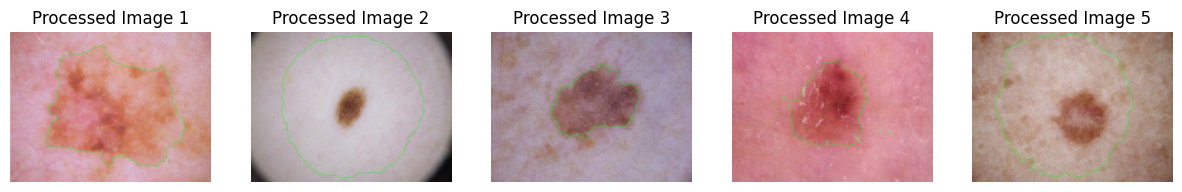

In [3]:
# Function to display a few processed images
def display_processed_images(folder_path, num_images=5):
    processed_images = os.listdir(folder_path)[:num_images]  # Load first 'num_images' images
    plt.figure(figsize=(15, 15))

    for i, img_file in enumerate(processed_images):
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Processed Image {i+1}")
        plt.axis('off')

    plt.show()

# Display processed images
print("Few images: ")
display_processed_images(output_folder, num_images=5)

[Missing File] Skipping: ISIC_0030912
[Missing File] Skipping: ISIC_0028933
[Missing File] Skipping: ISIC_0030585
[Missing File] Skipping: ISIC_0028394
[Missing File] Skipping: ISIC_0033697
[Missing File] Skipping: ISIC_0030062
[Missing File] Skipping: ISIC_0031213
[Missing File] Skipping: ISIC_0027799
[Missing File] Skipping: ISIC_0028100
[Missing File] Skipping: ISIC_0027960
[Missing File] Skipping: ISIC_0028872
[Missing File] Skipping: ISIC_0031317
[Missing File] Skipping: ISIC_0033841
[Missing File] Skipping: ISIC_0026412
[Missing File] Skipping: ISIC_0033096
[Missing File] Skipping: ISIC_0024872
[Missing File] Skipping: ISIC_0026232
[Missing File] Skipping: ISIC_0027031
[Missing File] Skipping: ISIC_0026692
[Missing File] Skipping: ISIC_0025729
[Missing File] Skipping: ISIC_0031252
[Missing File] Skipping: ISIC_0029645
[Missing File] Skipping: ISIC_0028582
[Missing File] Skipping: ISIC_0024754
[Missing File] Skipping: ISIC_0032893
[Missing File] Skipping: ISIC_0027742
[Missing Fil

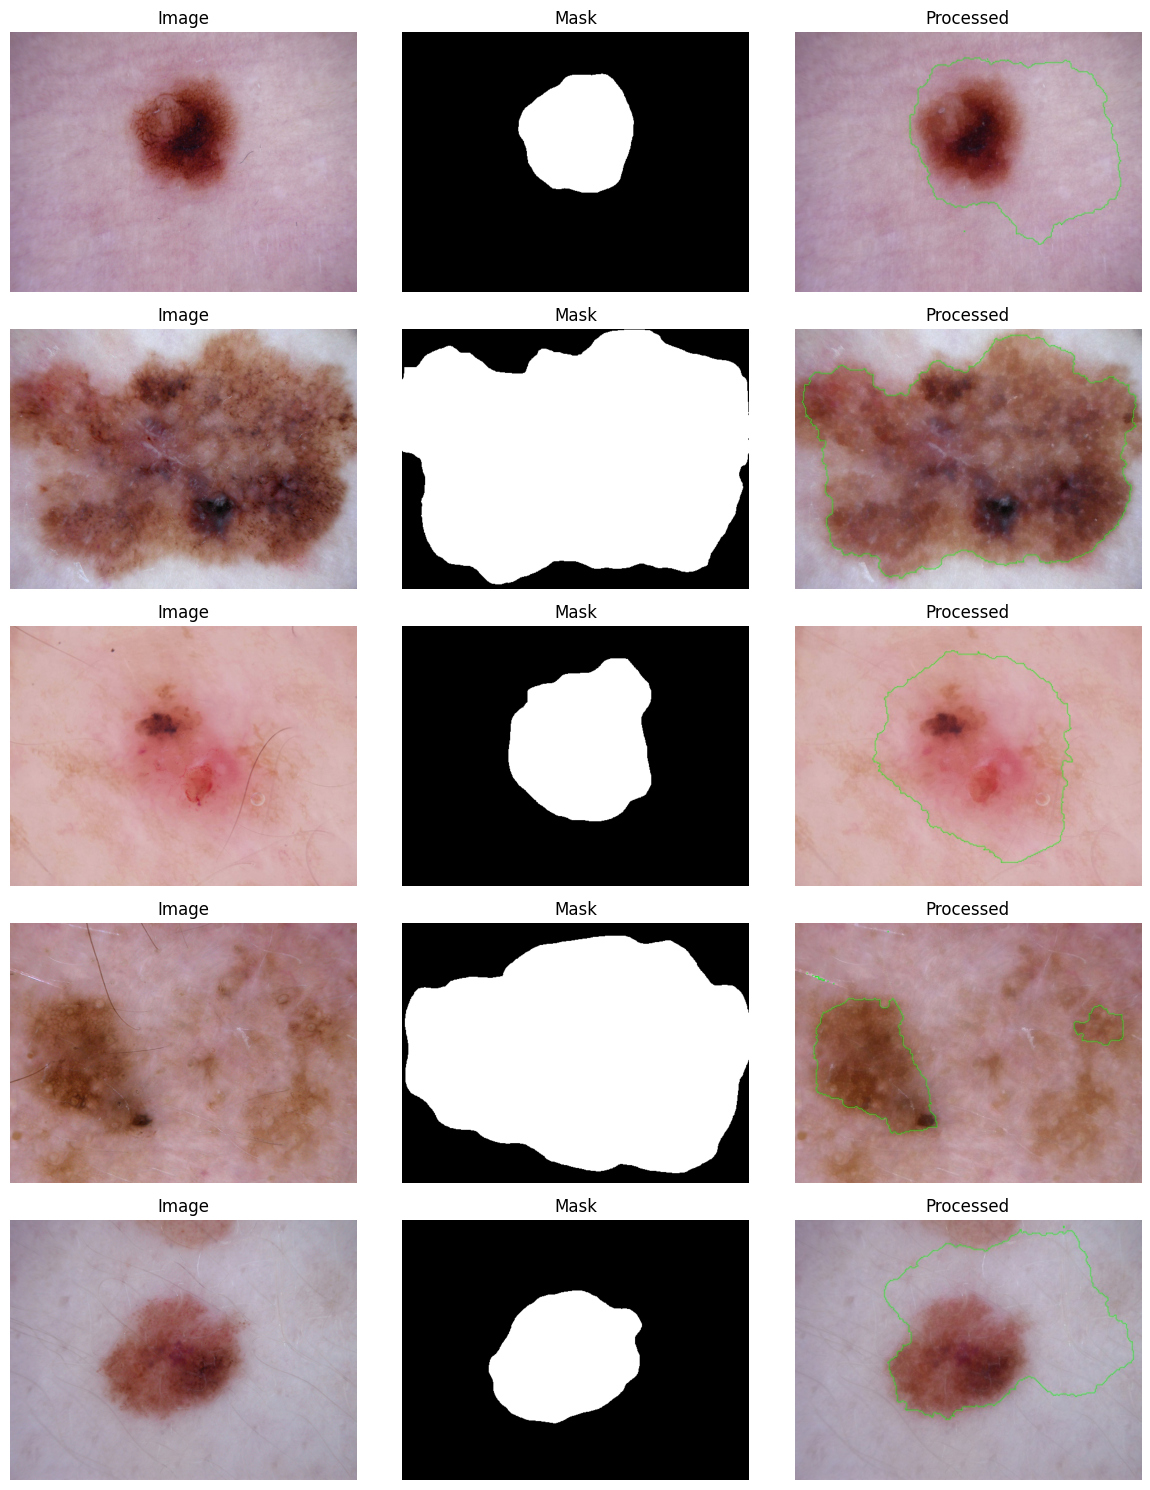

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def display_triplets(image_folder, mask_folder, processed_folder, base_names, num_samples=5):
    plt.figure(figsize=(12, num_samples * 3))
    count = 0

    for base in base_names:
        image_path = os.path.join(image_folder, f"{base}.jpg")
        mask_path = os.path.join(mask_folder, f"{base}_segmentation.png")
        processed_path = os.path.join(processed_folder, f"{base}.jpg")

        if not all(os.path.exists(p) for p in [image_path, mask_path, processed_path]):
            print(f"[Missing File] Skipping: {base}")
            continue

        try:
            image = Image.open(image_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
            processed = Image.open(processed_path).convert("RGB")
        except Exception as e:
            print(f"[Error Loading] {base}: {e}")
            continue

        plt.subplot(num_samples, 3, count * 3 + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, count * 3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, count * 3 + 3)
        plt.imshow(processed)
        plt.title("Processed")
        plt.axis("off")

        count += 1
        if count == num_samples:
            break

    if count == 0:
        print("No complete triplets found.")
    else:
        plt.tight_layout()
        plt.show()

image_folder = "/kaggle/input/ham1000-segmentation-and-classification/images"
mask_folder = "/kaggle/input/ham1000-segmentation-and-classification/masks"
processed_folder = "/kaggle/working/processed_images"

# Extract base names from images only
base_names = [
    fname[:-4] for fname in os.listdir(image_folder)
    if fname.endswith('.jpg')
]

display_triplets(image_folder, mask_folder, processed_folder, base_names, num_samples=5)

Streaming output truncated to the last 5000 lines.
Image not found or failed to load: /kaggle/working/processed_images/ISIC_0028776.jpg
Image not found or failed to load: /kaggle/working/processed_images/ISIC_0028777.jpg
Image not found or failed to load: /kaggle/working/processed_images/ISIC_0028778.jpg
Image not found or failed to load: /kaggle/working/processed_images/ISIC_0028779.jpg
Image not found or failed to load: /kaggle/working/processed_images/ISIC_0028780.jpg
Image not found or failed to load: /kaggle/working/processed_images/ISIC_0028783.jpg
Image not found or failed to load: /kaggle/working/processed_images/ISIC_0028784.jpg
Image not found or failed to load: /kaggle/working/processed_images/ISIC_0028785.jpg
Image not found or failed to load: /kaggle/working/processed_images/ISIC_0028786.jpg
Image not found or failed to load: /kaggle/working/processed_images/ISIC_0028787.jpg
Image not found or failed to load: /kaggle/working/processed_images/ISIC_0028788.jpg
Image not foun

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


=== RandomForest Evaluation ===
Accuracy: 0.6300
Precision (macro): 0.1433
Recall (macro): 0.1480
F1-Score (macro): 0.1386

Classification Report:
              precision    recall  f1-score   support

         MEL       0.00      0.00      0.00        23
          NV       0.70      0.91      0.79       135
         BCC       0.00      0.00      0.00         9
       AKIEC       0.00      0.00      0.00         7
         BKL       0.30      0.12      0.18        24
          DF       0.00      0.00      0.00         1
        VASC       0.00      0.00      0.00         1

    accuracy                           0.63       200
   macro avg       0.14      0.15      0.14       200
weighted avg       0.51      0.63      0.56       200



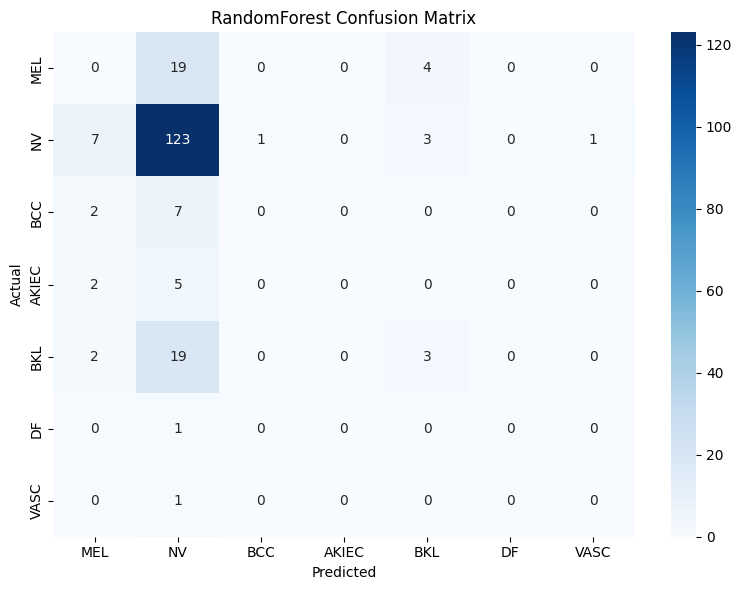

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:14:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


=== XGBoost Evaluation ===
Accuracy: 0.6350
Precision (macro): 0.1993
Recall (macro): 0.1693
F1-Score (macro): 0.1704

Classification Report:
              precision    recall  f1-score   support

         MEL       0.17      0.09      0.11        23
          NV       0.71      0.90      0.80       135
         BCC       0.33      0.11      0.17         9
       AKIEC       0.00      0.00      0.00         7
         BKL       0.18      0.08      0.11        24
          DF       0.00      0.00      0.00         1
        VASC       0.00      0.00      0.00         1

    accuracy                           0.64       200
   macro avg       0.20      0.17      0.17       200
weighted avg       0.54      0.64      0.57       200



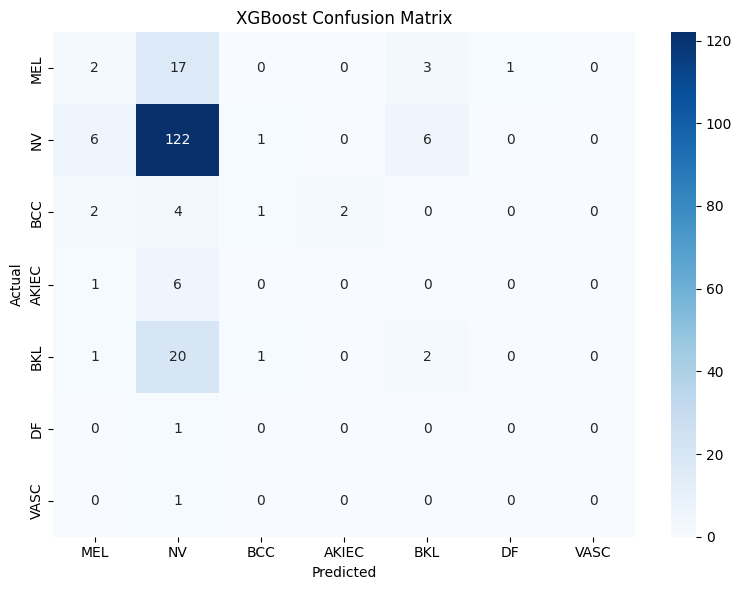

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1012
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 4
[LightGBM] [Info] Start training from score -2.120264
[LightGBM] [Info] Start training from score -0.385662
[LightGBM] [Info] Start training from score -3.129264
[LightGBM] [Info] Start training from score -3.688879
[LightGBM] [Info] Start training from score -2.184802
[LightGBM] [Info] Start training from score -4.892852
[LightGBM] [Info] Start training from score -4.487387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

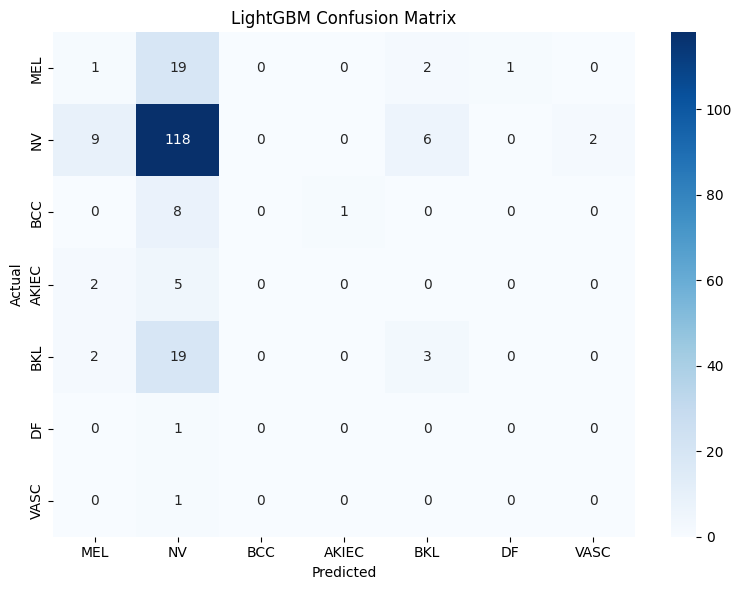

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


=== LogisticRegression Evaluation ===
Accuracy: 0.6750
Precision (macro): 0.0964
Recall (macro): 0.1429
F1-Score (macro): 0.1151

Classification Report:
              precision    recall  f1-score   support

         MEL       0.00      0.00      0.00        23
          NV       0.68      1.00      0.81       135
         BCC       0.00      0.00      0.00         9
       AKIEC       0.00      0.00      0.00         7
         BKL       0.00      0.00      0.00        24
          DF       0.00      0.00      0.00         1
        VASC       0.00      0.00      0.00         1

    accuracy                           0.68       200
   macro avg       0.10      0.14      0.12       200
weighted avg       0.46      0.68      0.54       200



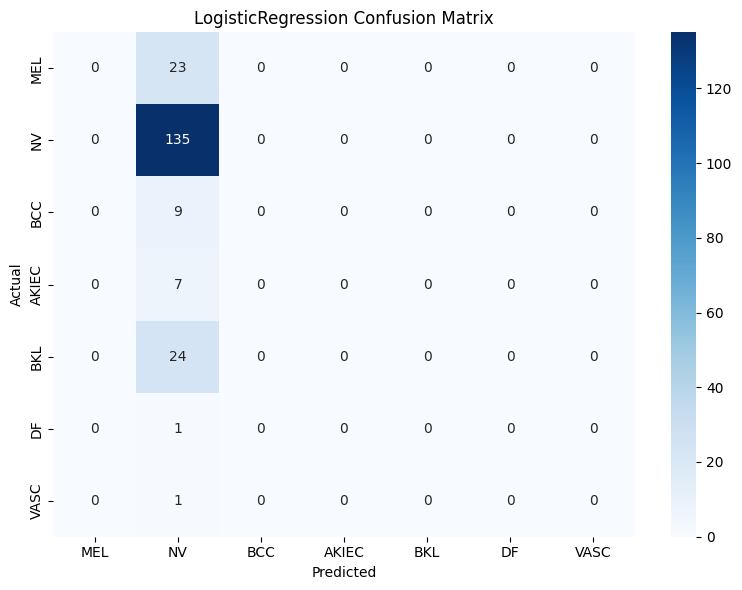


=== Final Model Performance Summary ===
Model          Accuracy  Precision  Recall  F1-Score
--------------------------------------------------
RandomForest   0.6300    0.1433    0.1480    0.1386
XGBoost        0.6350    0.1993    0.1693    0.1704
LightGBM       0.6100    0.1477    0.1489    0.1424
LogisticRegression 0.6750    0.0964    0.1429    0.1151


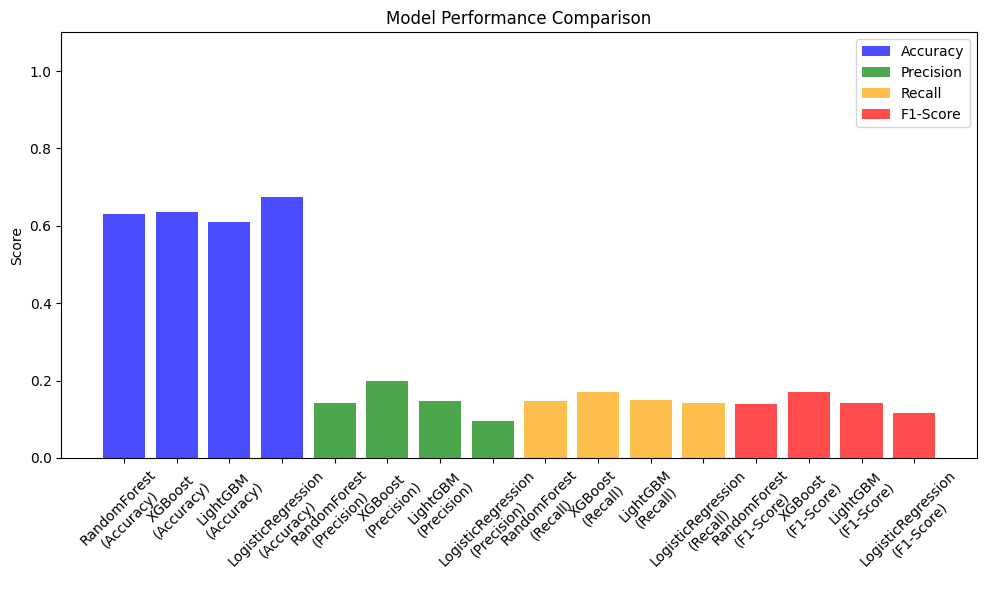

In [5]:
import cv2
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Load images and labels
def load_data(image_folder, csv_path, class_columns):
    df = pd.read_csv(csv_path)
    images, labels = [], []

    for _, row in df.iterrows():
        image_name = row['image'].strip() + ".jpg"
        image_path = os.path.join(image_folder, image_name)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            images.append(cv2.resize(image, (64, 64)))
            label_vector = row[class_columns].values.astype(int)
            label = np.argmax(label_vector)
            labels.append(label)
        else:
            print(f"Image not found or failed to load: {image_path}")

    return np.array(images), np.array(labels)

def extract_contour_features(images):
    features = []
    for img in images:
        edges = cv2.Canny(img, 100, 200)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        areas = [cv2.contourArea(cnt) for cnt in contours]
        perimeters = [cv2.arcLength(cnt, True) for cnt in contours]
        features.append([
            np.mean(areas) if areas else 0,
            np.std(areas) if areas else 0,
            np.mean(perimeters) if perimeters else 0,
            np.std(perimeters) if perimeters else 0
        ])
    return np.array(features)

def prepare_data(images, labels):
    X = extract_contour_features(images)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, labels, scaler

def train_and_evaluate(X_train, y_train, X_test, y_test, scaler, model_name, class_names):
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=50, n_jobs=-1),
        "XGBoost": XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='mlogloss'),
        "LightGBM": LGBMClassifier(n_estimators=50),
        "LogisticRegression": LogisticRegression(max_iter=1000)
    }

    c_model = models[model_name]
    c_model.fit(X_train, y_train)
    y_pred = c_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    joblib.dump(c_model, f"{model_name}_model.joblib")
    joblib.dump(scaler, "scaler.joblib")

    print(f"\n=== {model_name} Evaluation ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-Score (macro): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, f1, y_pred

def plot_metrics(results):
    plt.figure(figsize=(10, 6))
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    colors = ['blue', 'green', 'orange', 'red']

    for i, metric in enumerate(metrics):
        plt.bar([c_model + f"\n({metric})" for c_model in results.keys()], [res[i] for res in results.values()], color=colors[i], alpha=0.7, label=metric)

    plt.ylabel("Score")
    plt.title("Model Performance Comparison")
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

def main():
    image_folder = "/kaggle/working/processed_images"
    csv_path = "/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv"
    class_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
    class_names = class_columns

    images, labels = load_data(image_folder, csv_path, class_columns)
    X, y, scaler = prepare_data(images, labels)

    X_train, X_test, y_train, y_test, train_images, test_images = train_test_split(
        X, y, images, test_size=0.2, random_state=42
    )

    results = {}
    y_preds = {}

    for model_name in ["RandomForest", "XGBoost", "LightGBM", "LogisticRegression"]:
        acc, prec, rec, f1, y_pred = train_and_evaluate(X_train, y_train, X_test, y_test, scaler, model_name, class_names)
        results[model_name] = (acc, prec, rec, f1)
        y_preds[model_name] = y_pred

    print("\n=== Final Model Performance Summary ===")
    print("Model          Accuracy  Precision  Recall  F1-Score")
    print("-" * 50)
    for c_model, (acc, prec, rec, f1) in results.items():
        print(f"{c_model:<14} {acc:.4f}    {prec:.4f}    {rec:.4f}    {f1:.4f}")

    plot_metrics(results)

if __name__ == "__main__":
    main()

In [7]:
l_gbm_model = joblib.load("LightGBM_model.joblib")
l_gbm_scaler = joblib.load("scaler.joblib")

In [8]:
l_gbm_model

LGBMClassifier(n_estimators=50)

In [9]:
l_gbm_scaler

StandardScaler()

In [12]:
# prompt: Write the complete code to predict using my trained model l_gbm_model and using my images data for 5 random images

import os
import cv2
import numpy as np
import random
import joblib

# ... (Your existing code)

def predict_on_random_images(model, scaler, image_folder, num_images=5):
    """Predicts classes for random images using the trained model."""

    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    random_images = random.sample(image_files, min(num_images, len(image_files)))

    predictions = []
    for image_file in random_images:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Error: Could not read image {image_path}")
            continue

        resized_image = cv2.resize(image, (64, 64))  # Resize to match training data
        features = extract_contour_features(np.array([resized_image]))
        scaled_features = scaler.transform(features)  # Scale using the same scaler as training
        prediction = model.predict(scaled_features)[0]  # Get the predicted class
        predictions.append((image_file, prediction))

    return predictions

# Example usage
image_folder = "/kaggle/working/processed_images"  # Replace with your image folder
predictions = predict_on_random_images(l_gbm_model, l_gbm_scaler, image_folder)

for image_file, prediction in predictions:
    print(f"Image: {image_file}, Predicted Class: {prediction}")


Image: ISIC_0030955.jpg, Predicted Class: 1
Image: ISIC_0024392.jpg, Predicted Class: 1
Image: ISIC_0027783.jpg, Predicted Class: 1
Image: ISIC_0025493.jpg, Predicted Class: 1
Image: ISIC_0033480.jpg, Predicted Class: 4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
# prompt: Using the above code write the name of the skin disease also based on the number of predicted class

import numpy as np
# ... (Your existing code)

def predict_on_random_images(model, scaler, image_folder, num_images=5):
    """Predicts classes for random images using the trained model."""

    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    random_images = random.sample(image_files, min(num_images, len(image_files)))

    predictions = []
    for image_file in random_images:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Error: Could not read image {image_path}")
            continue

        resized_image = cv2.resize(image, (64, 64))  # Resize to match training data
        features = extract_contour_features(np.array([resized_image]))
        scaled_features = scaler.transform(features)  # Scale using the same scaler as training
        prediction = model.predict(scaled_features)[0]  # Get the predicted class

        # Map prediction to skin disease name
        class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
        predicted_disease = class_names[prediction]

        predictions.append((image_file, prediction, predicted_disease))

    return predictions

# Example usage
image_folder = "/kaggle/working/processed_images"  # Replace with your image folder
predictions = predict_on_random_images(l_gbm_model, l_gbm_scaler, image_folder)

for image_file, prediction_index, predicted_disease in predictions:
    print(f"Image: {image_file}, Predicted Class Index: {prediction_index}, Predicted Disease: {predicted_disease}")


Image: ISIC_0027060.jpg, Predicted Class Index: 0, Predicted Disease: MEL
Image: ISIC_0025479.jpg, Predicted Class Index: 1, Predicted Disease: NV
Image: ISIC_0033380.jpg, Predicted Class Index: 1, Predicted Disease: NV
Image: ISIC_0026644.jpg, Predicted Class Index: 4, Predicted Disease: BKL
Image: ISIC_0027570.jpg, Predicted Class Index: 1, Predicted Disease: NV


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


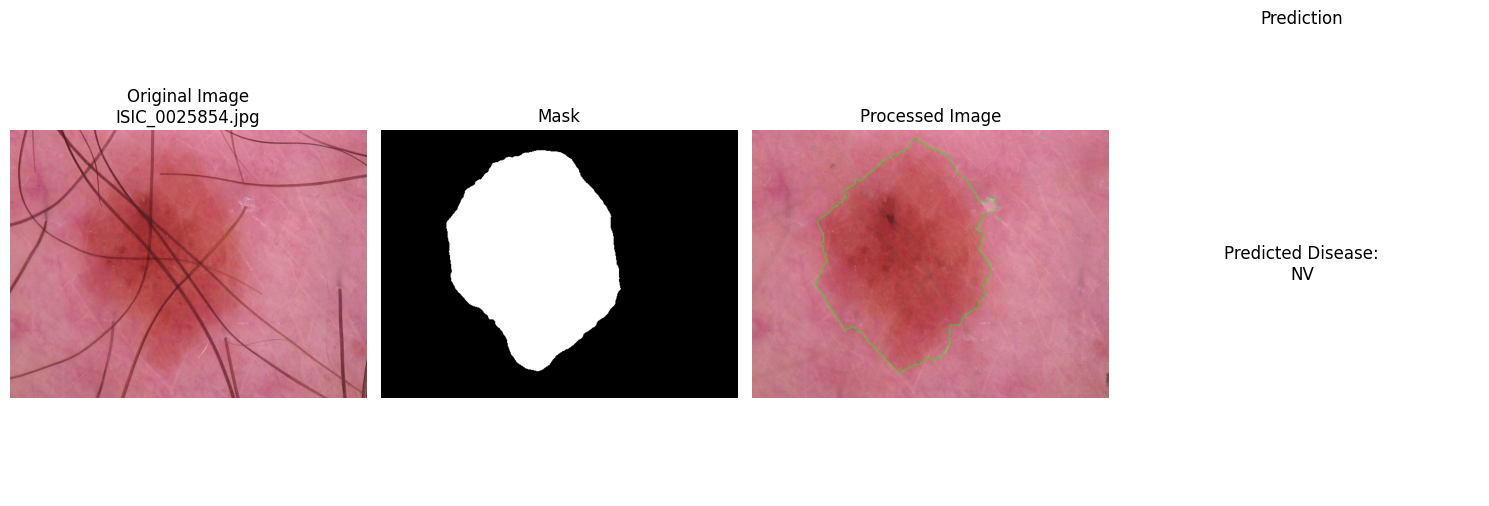

In [44]:
# prompt: Now write the complete function, first take the random images, provide the images along with the masked_image and processed image also beside it provide the predicted disease. You can use the trained model for mask image generation and use the trained l_gmb_model for the disease prediction

import matplotlib.pyplot as plt
def display_results(image_folder, mask_folder, processed_folder, predictions):
    """Displays original, masked, processed images along with predictions."""
    plt.figure(figsize=(15, len(predictions) * 5))  # Adjust figure size as needed

    for i, (image_file, prediction_index, predicted_disease) in enumerate(predictions):
        image_path = os.path.join(image_folder, image_file)
        mask_path = os.path.join(mask_folder, image_file.replace(".jpg", "_segmentation.png")) # Assuming mask file naming
        processed_path = os.path.join(processed_folder, image_file)


        try:
            original_image = Image.open(image_path).convert("RGB")
            mask_image = Image.open(mask_path).convert("L") # Load mask as grayscale
            processed_image = Image.open(processed_path).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Skipping {image_file} - One or more files not found.")
            continue
        except Exception as e:
            print(f"Error loading images for {image_file}: {e}")
            continue


        plt.subplot(len(predictions), 4, i * 4 + 1)
        plt.imshow(original_image)
        plt.title(f"Original Image\n{image_file}")
        plt.axis("off")

        plt.subplot(len(predictions), 4, i * 4 + 2)
        plt.imshow(mask_image, cmap='gray') # Display the mask in grayscale
        plt.title("Mask")
        plt.axis("off")

        plt.subplot(len(predictions), 4, i * 4 + 3)
        plt.imshow(processed_image)
        plt.title("Processed Image")
        plt.axis("off")

        plt.subplot(len(predictions), 4, i * 4 + 4)
        plt.text(0.5, 0.5, f"Predicted Disease:\n{predicted_disease}", ha='center', va='center', fontsize=12)
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage (assuming you have predictions from predict_on_random_images)
image_folder = "/kaggle/input/ham1000-segmentation-and-classification/images"  # Original image folder
mask_folder = "/kaggle/input/ham1000-segmentation-and-classification/masks" # Mask folder
processed_folder = "/kaggle/working/processed_images"  # Processed image folder
predictions = predict_on_random_images(l_gbm_model, l_gbm_scaler, image_folder) # Get predictions


display_results(image_folder, mask_folder, processed_folder, predictions)


In [28]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import tensorflow.keras.backend as K

# Custom Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss
def dice_loss(y_true, y_pred):
    return 1. - dice_coefficient(y_true, y_pred)

# IOU (Intersection over Union)
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Load model without compilation
model_path = '/content/final_unet_skin_lesion.h5'
model = tf.keras.models.load_model(model_path, compile=False)  # Force compile=False

# Get expected input size (e.g., 128x128)
input_shape = model.input_shape[1:3]  # (128, 128)
print(f"Expected model input shape: {input_shape}")

# Recompile the model with correct loss & metrics
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient, iou_metric])
model.summary()

Expected model input shape: (128, 128)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 128, 128,  │          0 │ conv2d_19[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ leaky_re_lu_18[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ leaky_re_lu_19[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ dropout_9[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_20      │ (None, 64, 64,    │          0 │ conv2d_21[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ leaky_re_lu_20[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_21      │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ leaky_re_lu_21[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ dropout_10[0][0]

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [57]:
# prompt: Now write me the complete function which take the input image and process it and based on my trained model provide me the processed image and mask image and predicted disease

import cv2
import numpy as np
from PIL import Image

def predict_disease(image_path, model, scaler):
    """Predicts the skin disease for a given image."""

    # 1. Preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return None, None, None

    resized_image = cv2.resize(image, (64, 64))  # Resize to match training data
    features = extract_contour_features(np.array([resized_image]))
    scaled_features = scaler.transform(features)

    # 2. Predict the class
    prediction_index = model.predict(scaled_features)[0]
    class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
    predicted_disease = class_names[prediction_index]

    # 3. Create Mask (using the create_mask function from the original code)
    mask = create_mask(image_path)
    if mask is None:
        return None, None, predicted_disease # Return None mask and the prediction

    # 4. Draw contours on the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    processed_image = draw_contours(original_image, mask)

    #Convert the processed image from numpy array to PIL image for display and saving
    processed_image_pil = Image.fromarray(processed_image)

    return processed_image_pil, mask, predicted_disease


# Example Usage (assuming you have l_gbm_model, l_gbm_scaler defined)
image_path = "/kaggle/working/processed_images/ISIC_0024308.jpg" # Example image, replace with your image
processed_img, mask_img, predicted_disease = predict_disease(image_path, l_gbm_model, l_gbm_scaler)

if processed_img:
  print(f"Predicted Disease: {predicted_disease}")
  processed_img.save("processed_output.jpg") # Save the processed image
  print("Processed image saved as processed_output.jpg")
  # ...further processing or display of the mask_img...


Error: Could not read image /kaggle/working/processed_images/ISIC_0024308.jpg


In [59]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Load the U-Net model (only once)
model_path = "/content/final_unet_skin_lesion.h5"
try:
    model = tf.keras.models.load_model(model_path, compile=False)
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    model = None

# Get expected model input shape
input_shape = model.input_shape[1:3] if model else (128, 128)
print(f"🔹 Model expects input size: {input_shape}")

# Create output directory
os.makedirs("/content/predictions", exist_ok=True)

# 🔧 Main Function: Predict, Save, and Visualize
def predict_and_visualize_unet_segmentation(image_path, save_prefix="/content/predictions/output"):
    if model is None:
        print("❌ Model not loaded.")
        return None, None, None

    # Load and preprocess image
    original = cv2.imread(image_path)
    if original is None:
        print(f"❌ Could not read: {image_path}")
        return None, None, None

    resized = cv2.resize(original, input_shape)
    img_input = resized / 255.0
    img_input = np.expand_dims(img_input, axis=0)

    # Predict mask
    pred_mask = model.predict(img_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255
    pred_mask_resized = cv2.resize(pred_mask, (original.shape[1], original.shape[0]))

    # Draw contours on image
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    contours, _ = cv2.findContours(pred_mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contoured_image = original_rgb.copy()
    if contours:
        cv2.drawContours(contoured_image, contours, -1, (0, 255, 0), 2)

    # Save outputs
    mask_path = f"{save_prefix}_mask.png"
    contoured_path = f"{save_prefix}_contoured.png"
    cv2.imwrite(mask_path, pred_mask_resized)
    cv2.imwrite(contoured_path, cv2.cvtColor(contoured_image, cv2.COLOR_RGB2BGR))
    print(f"📝 Saved mask to: {mask_path}")
    print(f"📝 Saved contoured image to: {contoured_path}")

    return original_rgb, pred_mask_resized, contoured_image


✅ Model loaded successfully.
🔹 Model expects input size: (128, 128)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
📝 Saved mask to: /content/predictions/output_mask.png
📝 Saved contoured image to: /content/predictions/output_contoured.png


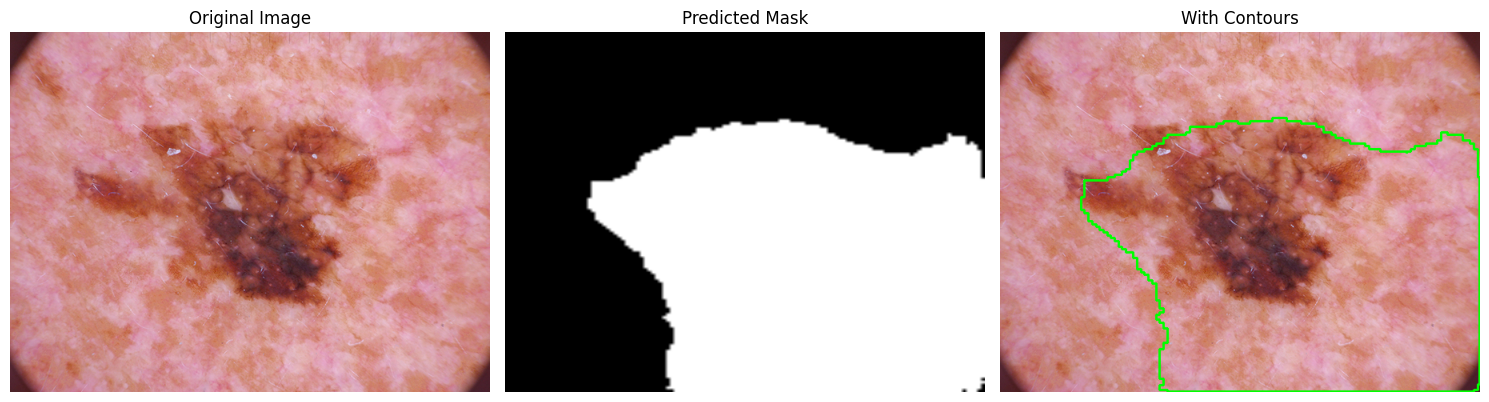

In [62]:
# Example input image path
input_image_path = "/content/ISIC_0024310.jpg"  # Change this to your image

# Call the function
original, mask, contoured = predict_and_visualize_unet_segmentation(input_image_path)

# Visualize all 3 outputs
if original is not None:
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(contoured)
    plt.title("With Contours")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("❌ Processing failed.")


✅ Model loaded.
🎯 All images processed!
🖼️ Found 12 images in: /content/sample_images


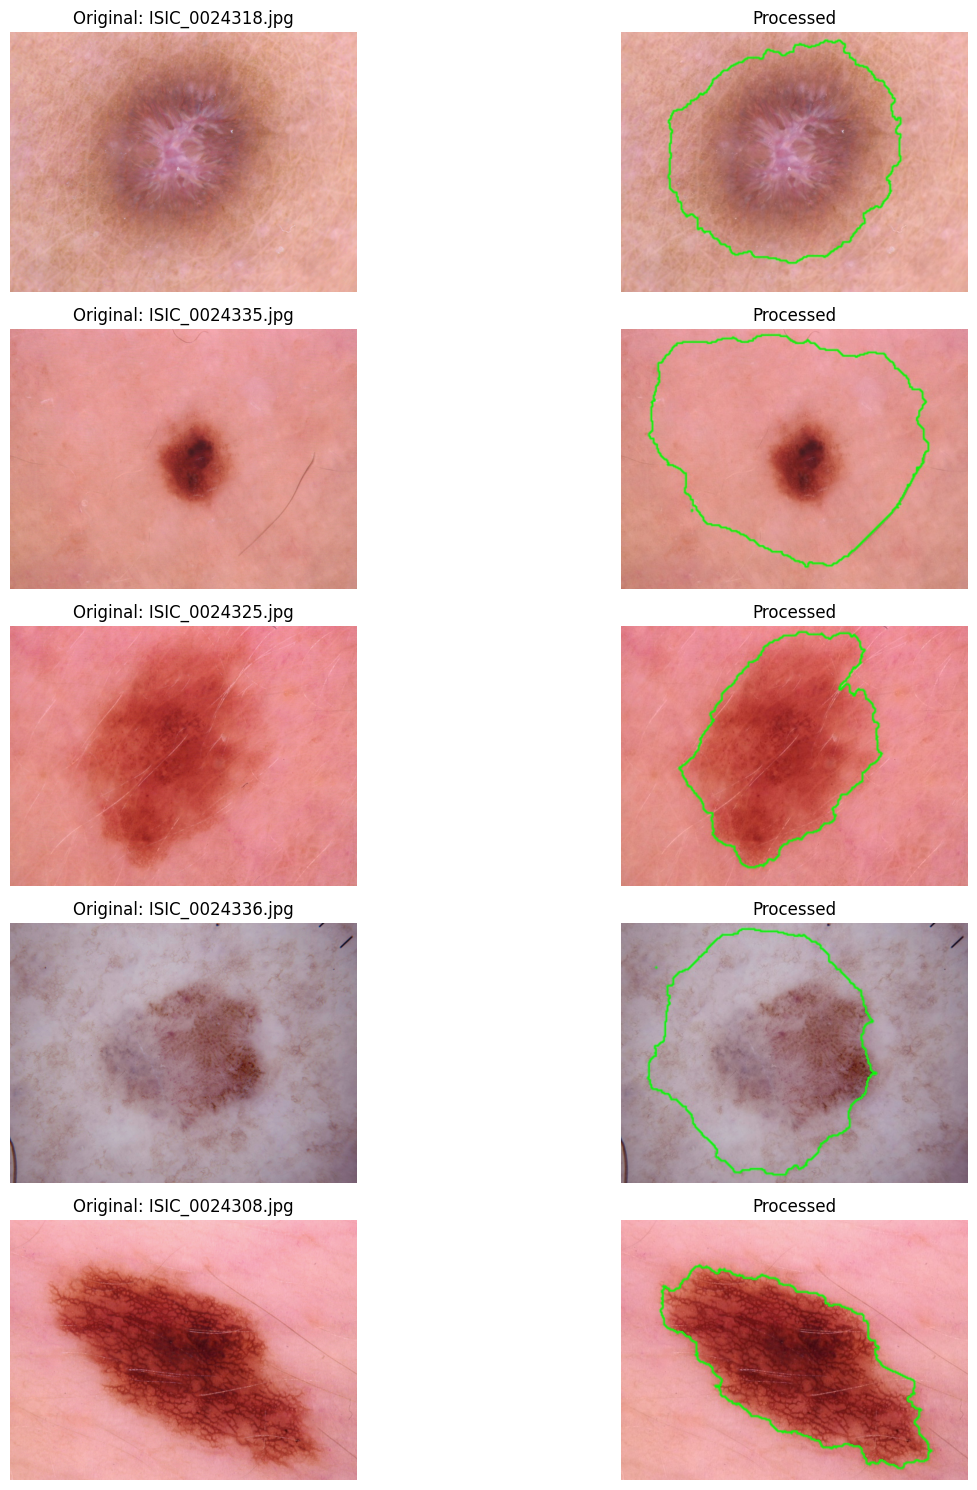

In [91]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

def load_model(model_path):
    try:
        model = tf.keras.models.load_model(model_path, compile=False)
        print("✅ Model loaded.")
        return model
    except Exception as e:
        print(f"❌ Failed to load model: {e}")
        return None

def create_grabcut_mask(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None

    h, w = image.shape[:2]
    small = cv2.resize(image, (w // 2, h // 2))
    mask = np.zeros(small.shape[:2], np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)
    rect = (5, 5, small.shape[1] - 10, small.shape[0] - 10)

    cv2.grabCut(small, mask, rect, bgModel, fgModel, 2, cv2.GC_INIT_WITH_RECT)
    binary = np.where((mask == 2) | (mask == 0), 0, 255).astype('uint8')
    return cv2.resize(binary, (w, h), interpolation=cv2.INTER_NEAREST)

def draw_contours(img, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = img.copy()
    if contours:
        cv2.drawContours(out, contours, -1, (0, 255, 0), 2)
    return out

def process_folder(model_path, image_folder, output_folder):
    model = load_model(model_path)
    if model is None:
        return

    os.makedirs(output_folder, exist_ok=True)
    images = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for i, fname in enumerate(images, 1):
        img_path = os.path.join(image_folder, fname)
        out_path = os.path.join(output_folder, fname)

        mask = create_grabcut_mask(img_path)
        if mask is None:
            print(f"⚠️ Skipped: {fname}")
            continue

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        processed = draw_contours(image, mask)
        cv2.imwrite(out_path, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))

        if i % 50 == 0:
            print(f"✅ Processed {i} images...")

    print("🎯 All images processed!")

def show_processed_samples(original_folder, processed_folder, n=5):
    all_files = os.listdir(original_folder)
    image_files = [f for f in all_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print("❌ No image files found in the original folder.")
        return

    print(f"🖼️ Found {len(image_files)} images in: {original_folder}")
    files_to_show = image_files[:n]
    plt.figure(figsize=(15, 3 * len(files_to_show)))

    for i, fname in enumerate(files_to_show):
        orig_path = os.path.join(original_folder, fname)
        proc_path = os.path.join(processed_folder, fname)

        if not os.path.exists(proc_path):
            print(f"⚠️ Processed image not found for: {fname}")
            continue

        try:
            original = Image.open(orig_path).convert("RGB")
            processed = Image.open(proc_path).convert("RGB")
        except Exception as e:
            print(f"⚠️ Error loading {fname}: {e}")
            continue

        plt.subplot(n, 2, i * 2 + 1)
        plt.imshow(original)
        plt.title(f"Original: {fname}")
        plt.axis("off")

        plt.subplot(n, 2, i * 2 + 2)
        plt.imshow(processed)
        plt.title("Processed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# === Run your complete pipeline ===

model_path = "/content/final_unet_skin_lesion.h5"
input_images = "/content/sample_images"
output_images = "/content/sample_processed"

process_folder(model_path, input_images, output_images)
show_processed_samples(input_images, output_images, n=5)


In [87]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

def load_model(model_path):
    try:
        model = tf.keras.models.load_model(model_path, compile=False)
        print("✅ Model loaded.")
        return model
    except Exception as e:
        print(f"❌ Failed to load model: {e}")
        return None

def create_grabcut_mask(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    h, w = image.shape[:2]
    small = cv2.resize(image, (w // 2, h // 2))
    mask = np.zeros(small.shape[:2], np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)
    rect = (5, 5, small.shape[1] - 10, small.shape[0] - 10)
    cv2.grabCut(small, mask, rect, bgModel, fgModel, 2, cv2.GC_INIT_WITH_RECT)
    binary = np.where((mask == 2) | (mask == 0), 0, 255).astype('uint8')
    return cv2.resize(binary, (w, h), interpolation=cv2.INTER_NEAREST)

def draw_contours(img, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = img.copy()
    if contours:
        cv2.drawContours(out, contours, -1, (0, 255, 0), 2)
    return out

def process_folder(model_path, image_folder, output_folder):
    model = load_model(model_path)
    if model is None:
        return
    os.makedirs(output_folder, exist_ok=True)
    images = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for i, fname in enumerate(images, 1):
        img_path = os.path.join(image_folder, fname)
        out_path = os.path.join(output_folder, fname)
        mask = create_grabcut_mask(img_path)
        if mask is None:
            print(f"⚠️ Skipped: {fname}")
            continue
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        processed = draw_contours(image, mask)
        cv2.imwrite(out_path, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))
        if i % 50 == 0:
            print(f"✅ Processed {i} images...")
    print("🎯 All images processed!")

def process_single_image(model_path, image_path, output_folder):
    model = load_model(model_path)
    if model is None:
        return

    os.makedirs(output_folder, exist_ok=True)

    mask = create_grabcut_mask(image_path)
    if mask is None:
        print(f"❌ Could not create mask for: {image_path}")
        return

    original = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    result = draw_contours(original_rgb, mask)

    # Build output filename
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    output_path = os.path.join(output_folder, base_name + "_processed.jpg")

    cv2.imwrite(output_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    print(f"✅ Processed single image saved as: {output_path}")

    # Optional visualization
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_rgb)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("GrabCut Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(result)
    plt.title("Contours")
    plt.axis("off")

    plt.tight_layout()
    plt.show()



✅ Model loaded.
✅ Processed single image saved as: /content/sample_processed/ISIC_0024327_processed.jpg


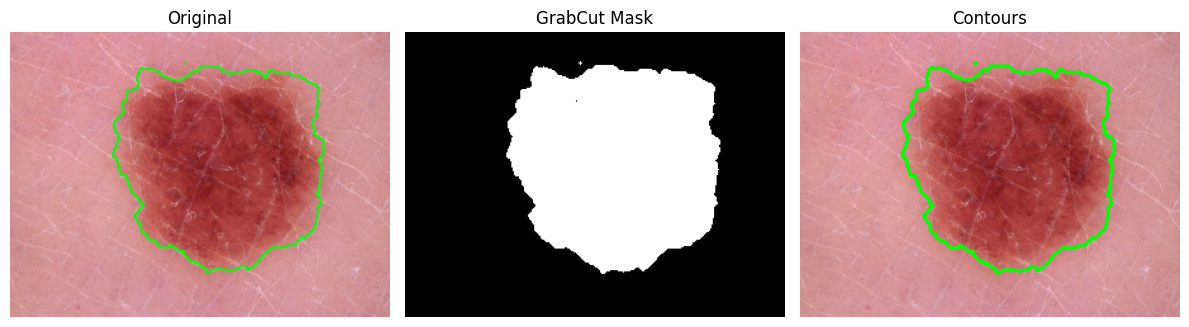

In [88]:
process_single_image(
    model_path="/content/final_unet_skin_lesion.h5",
    image_path="/content/sample_processed/ISIC_0024327.jpg",
    output_folder="/content/sample_processed"
)


In [89]:
process_folder(
    model_path="/content/final_unet_skin_lesion.h5",
    image_folder="/content/sample_images",
    output_folder="/content/sample_processed"
)


✅ Model loaded.
🎯 All images processed!


✅ Model loaded.
✅ Processed single image saved as: /content/sample_processed/ISIC_0024317_processed.jpg


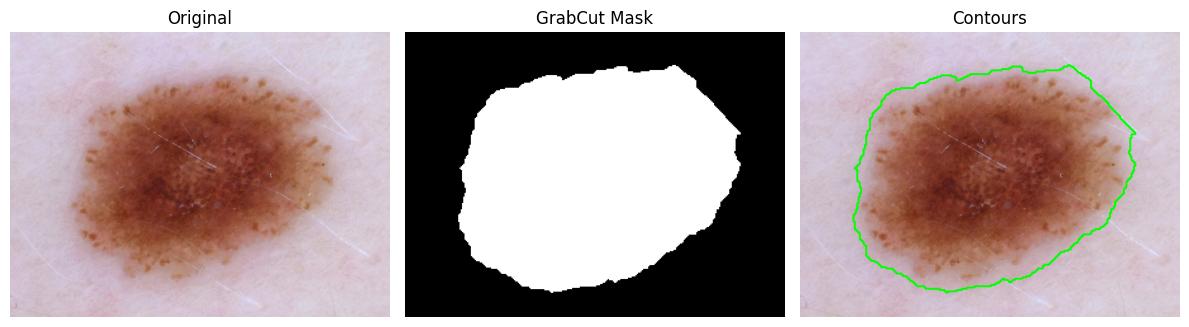

In [95]:
model_path="/content/final_unet_skin_lesion.h5"
output_folder = "/content/sample_processed"
image_path = "/content/sample_images/ISIC_0024317.jpg"
process_single_image(
    model_path,
    image_path,
    output_folder
)


In [103]:
import cv2
import numpy as np
import joblib

# --- Load model and scaler ---
l_gbm_model = joblib.load("LightGBM_model.joblib")
l_gbm_scaler = joblib.load("scaler.joblib")

# --- Your class names ---
class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

def extract_single_image_features(image_path):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"❌ Failed to load image: {image_path}")
        return None

    image = cv2.resize(image, (64, 64))  # Resize to match training shape
    edges = cv2.Canny(image, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(cnt) for cnt in contours]
    perimeters = [cv2.arcLength(cnt, True) for cnt in contours]

    feature_vector = np.array([[
        np.mean(areas) if areas else 0,
        np.std(areas) if areas else 0,
        np.mean(perimeters) if perimeters else 0,
        np.std(perimeters) if perimeters else 0
    ]])

    return feature_vector

def predict_disease_class(image_path, model, scaler, class_names):
    features = extract_single_image_features(image_path)
    if features is None:
        return

    # Normalize features
    features_scaled = scaler.transform(features)

    # Predict class
    predicted_class = model.predict(features_scaled)[0]
    predicted_label = class_names[predicted_class]

    print(f"✅ Predicted Class Index: {predicted_class}")
    print(f"🩺 Predicted Disease: {predicted_label}")
    return predicted_class, predicted_label


In [105]:
image_path = "/content/sample_images/ISIC_0024318.jpg"
predict_disease_class(image_path, l_gbm_model, l_gbm_scaler, class_names)


✅ Predicted Class Index: 1
🩺 Predicted Disease: NV


(np.int64(1), 'NV')

🚀 Processing image: /content/sample_images/ISIC_0024326.jpg


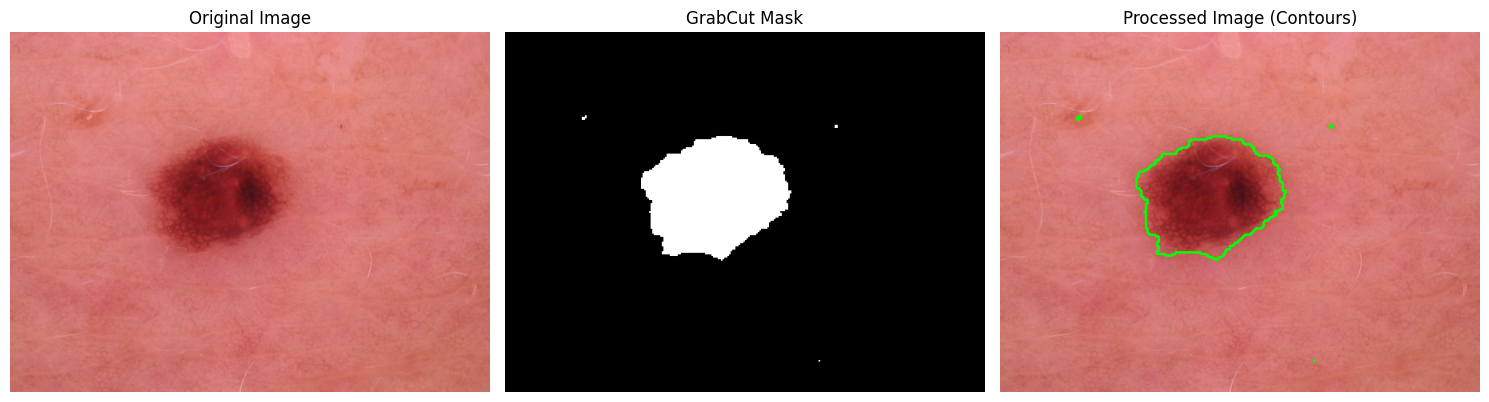

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🔍 EfficientNetB0 Prediction:
Predicted Class Index: 5
Disease Name: DF
Confidence: 0.9268
----------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🔍 ResNet50 Prediction:
Predicted Class Index: 4
Disease Name: BKL
Confidence: 1.0000
----------------------------------------


In [107]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

# --- Class names ---
class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# --- Model input size ---
IMAGE_SIZE = (224, 224)

# --- Load both models once ---
efficientnet_model = load_model("efficientnetb0_model.h5")
resnet_model = load_model("resnet50_model.h5")

# --- Create GrabCut mask ---
def create_grabcut_mask(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    h, w = image.shape[:2]
    small = cv2.resize(image, (w // 2, h // 2))
    mask = np.zeros(small.shape[:2], np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)
    rect = (5, 5, small.shape[1] - 10, small.shape[0] - 10)
    cv2.grabCut(small, mask, rect, bgModel, fgModel, 2, cv2.GC_INIT_WITH_RECT)
    binary = np.where((mask == 2) | (mask == 0), 0, 255).astype('uint8')
    return cv2.resize(binary, (w, h), interpolation=cv2.INTER_NEAREST)

# --- Draw contours on image using mask ---
def draw_contours(img, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = img.copy()
    if contours:
        cv2.drawContours(out, contours, -1, (0, 255, 0), 2)
    return out

# --- Prediction function ---
def predict_class_from_image(image_array, model, preprocess_fn, model_name):
    image = cv2.resize(image_array, IMAGE_SIZE)
    image = preprocess_fn(image.astype(np.float32))
    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)
    predicted_class = np.argmax(predictions)
    predicted_label = class_names[predicted_class]
    confidence = predictions[0][predicted_class]

    print(f"🔍 {model_name} Prediction:")
    print(f"Predicted Class Index: {predicted_class}")
    print(f"Disease Name: {predicted_label}")
    print(f"Confidence: {confidence:.4f}")
    print("-" * 40)
    return predicted_class, predicted_label

# --- Full pipeline function ---
def full_pipeline(image_path):
    print(f"🚀 Processing image: {image_path}")

    # Load original
    original = cv2.imread(image_path)
    if original is None:
        print(f"❌ Could not load image: {image_path}")
        return
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # Create mask
    mask = create_grabcut_mask(image_path)
    if mask is None:
        print(f"❌ Could not create mask for: {image_path}")
        return

    # Create processed (contoured) image
    processed = draw_contours(original_rgb, mask)

    # Plot all three images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_rgb)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("GrabCut Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(processed)
    plt.title("Processed Image (Contours)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Pass the processed image to disease prediction
    predict_class_from_image(processed, efficientnet_model, efficientnet_preprocess, "EfficientNetB0")
    predict_class_from_image(processed, resnet_model, resnet_preprocess, "ResNet50")

# --- Example usage ---
input_image_path = "/content/sample_images/ISIC_0024326.jpg"  # <-- your input image path
full_pipeline(input_image_path)
